In [28]:
# Mengakses google drive ke dalam google colaboratory
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
!pip3 install unidecode

In [30]:
!pip install nltk spacy gensim scikit-learn

import nltk
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import spacy

In [31]:
# Unduh resource NLTK (hanya perlu 1x)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Unduh model SpaCy (hanya perlu 1x)
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [32]:
# Mendefinisikan path dan cek keberadaan data
path = '/content/gdrive/MyDrive/MATA_KULIAH/SEM_7/NLP/Praktisi/Pertemuan 2/'


os.listdir(path)

['news_dataset.csv',
 'result_word2vec.model',
 'movierating.csv',
 'twitter_training.csv',
 'Rev_NLP_2_dataset_new.ipynb',
 'Tugas NLP_2.ipynb']

## Load Data
Data yang akan anda gunakan adalah data yang diambil dari twitter, dalam data ini, anda hanya memiliki data text saja. Selanjutnya anda ingin mencari tahu bagaimana sentiment dari user pengguna twitter.

In [33]:
# Load dataset
# df = pd.read_csv(os.path.join(path, 'twitter_dataset.csv'), header=None)
# Lihat beberapa baris pertama file mentah
with open(os.path.join(path, 'movierating.csv'), 'r', encoding='utf-8', errors='ignore') as f:
    for i in range(10):
        print(f.readline())

text,label

"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.,0"

When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. 

Dataset
> movierating.csv

berisi teks review panjang (banyak tanda kutip " dan koma , di dalamnya).
Kalau dibaca dengan pd.read_csv(), Output teks jadi rusak atau NaN.

In [34]:
import pandas as pd
import os

# Ganti path sesuai lokasi file di Colab
path = '/content/gdrive/MyDrive/MATA_KULIAH/SEM_7/NLP/Praktisi/Pertemuan 2/movierating.csv'

# Baca manual dengan parameter yang lebih toleran
path = '/content/gdrive/MyDrive/MATA_KULIAH/SEM_7/NLP/Praktisi/Pertemuan 2/movierating.csv'

# Baca manual agar aman
with open(path, 'r', encoding='latin-1') as f:
    lines = f.readlines()

texts, labels = [], []
for line in lines[1:]:
    idx = line.rstrip().rfind(',')
    if idx != -1:
        text_part = line[:idx].strip()
        label_part = line[idx+1:].strip()
        if label_part in ['0', '1']:
            texts.append(text_part)
            labels.append(int(label_part))

df = pd.DataFrame({'text': texts, 'label': labels})
print("Jumlah data:", df.shape)
df.head(3)

Jumlah data: (2689, 2)


,text,label
0,"When I put this movie in my DVD player, and sa...",0
1,Even though I have great interest in Biblical ...,0
2,A terrible movie as everyone has said. What ma...,0


Membuka file dan membaca semua baris ke dalam list bernama lines.

**Kenapa pakai latin-1?**

Karena file mengandung karakter seperti é atau ’ yang tidak bisa dibaca oleh utf-8.
latin-1 lebih “toleran” dan bisa membaca karakter Eropa barat tanpa error UnicodeDecodeError.

Next, Membuat dua list kosong untuk menyimpan:

*   texts: isi review (teks film)
*   labels: nilai label (0 = negatif, 1 = positif)

Next, Melakukan iterasi untuk setiap baris dalam file, tetapi melewati baris pertama (lines[1:]) karena itu header (text,label).

rstrip() menghapus karakter newline (\n) di akhir baris.
rfind(',') mencari posisi koma terakhir di baris tersebut.

Jika koma ditemukan (idx != -1), potong baris menjadi dua bagian:


1.   text_part = bagian sebelum koma terakhir (isi review).
2.   label_part = bagian setelah koma terakhir (label 0/1).
Lalu hapus spasi di kiri/kanan dengan .strip().

Next, Pastikan label benar-benar 0 atau 1 (bukan teks aneh). Simpan hasilnya ke dalam dua list:

*   texts.append(text_part)
*   labels.append(int(label_part)) (dikonversi ke integer)

Next, Membuat DataFrame Pandas dari dua list tersebut.




In [35]:
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2689 non-null   object
 1   label   2689 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.1+ KB


,text,label
0,"When I put this movie in my DVD player, and sa...",0
1,Even though I have great interest in Biblical ...,0


Sekarang anda telah mengubah nama kolom dan memiliki text data yang akan anda analisis sentimentnya. Namun sebelum itu akan dilakukan cleansing terlebih dahulu untuk memastikan tidak ada data yang duplikasi atau missing.

## Preprocessing
Mencari informasi dari data, baik jumlah baris dan kolom, maupun tipe dari data yang dimiliki.

In [36]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)         # hapus HTML
    text = re.sub(r'[^a-z\s]', '', text)      # hapus angka & simbol
    tokens = [w for w in text.split() if w not in stop_words]
    return tokens

df['tokens'] = df['text'].apply(clean_text)
df['clean_text'] = df['tokens'].apply(lambda x: ' '.join(x))

print("\nContoh hasil preprocessing:")
print(df[['text', 'tokens']].head(3))


Contoh hasil preprocessing:
                                                text  \
0  When I put this movie in my DVD player, and sa...   
1  Even though I have great interest in Biblical ...   
2  A terrible movie as everyone has said. What ma...   

                                              tokens  
0  [put, movie, dvd, player, sat, coke, chips, ex...  
1  [even, though, great, interest, biblical, movi...  
2  [terrible, movie, everyone, said, made, laugh,...  


## **N-Gram (Bigram)**

In [37]:
def get_ngrams(tokens, n=2):
    return [' '.join(gram) for gram in ngrams(tokens, n)]

df['bigrams'] = df['tokens'].apply(lambda x: get_ngrams(x, 2))

print("\nContoh Bigram:")
print(df[['tokens', 'bigrams']].head(3))


Contoh Bigram:
                                              tokens  \
0  [put, movie, dvd, player, sat, coke, chips, ex...   
1  [even, though, great, interest, biblical, movi...   
2  [terrible, movie, everyone, said, made, laugh,...   

                                             bigrams  
0  [put movie, movie dvd, dvd player, player sat,...  
1  [even though, though great, great interest, in...  
2  [terrible movie, movie everyone, everyone said...  


# **POS Tagging (Part of Speech)**

In [38]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
def get_pos_tags(text):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    return pos_tags

df['pos_tags'] = df['clean_text'].apply(get_pos_tags)

def get_adjectives(pos_tags):
    return [word for word, tag in pos_tags if tag.startswith('JJ')]

df['adjectives'] = df['pos_tags'].apply(get_adjectives)

print("\nContoh POS Tagging:")
print(df[['clean_text', 'adjectives']].head(3))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!



Contoh POS Tagging:
                                          clean_text  \
0  put movie dvd player sat coke chips expectatio...   
1  even though great interest biblical movies bor...   
2  terrible movie everyone said made laugh cameo ...   

                                          adjectives  
0  [coke, first, awsome, good, excellent, funny, ...  
1           [great, biblical, bad, acting, horrible]  
2  [terrible, cameo, mcnealy, microsoft, instrume...  


# **Named Entity Recognition (NER)**

In [39]:
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df['entities'] = df['text'].apply(extract_entities)

print("\nContoh Named Entity Recognition:")
print(df[['text', 'entities']].head(3))



Contoh Named Entity Recognition:
                                                text  \
0  When I put this movie in my DVD player, and sa...   
1  Even though I have great interest in Biblical ...   
2  A terrible movie as everyone has said. What ma...   

                                            entities  
0  [(first, ORDINAL), (Atlantis, PRODUCT), (first...  
1  [(Biblical, ORG), (every minute, TIME), (Joke,...  
2  [(Scott McNealy, PERSON), (SUN, ORG), (McNealy...  


# **Word2Vec Embedding**

In [40]:
model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, workers=4, sg=1)

# Cek kata yang mirip
try:
    print("\nKata yang mirip dengan 'good':")
    print(model.wv.most_similar('good'))
except KeyError:
    print("Kata 'good' tidak ditemukan di vocab.")

def get_vector(tokens):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['vector'] = df['tokens'].apply(get_vector)


Kata yang mirip dengan 'good':
[('funny', 0.9051389694213867), ('awesome', 0.9026574492454529), ('serious', 0.8957167267799377), ('cool', 0.8935659527778625), ('nice', 0.8930479884147644), ('decent', 0.8915882110595703), ('fine', 0.8862281441688538), ('ok', 0.881567120552063), ('overall', 0.8781682252883911), ('parts', 0.874675989151001)]


# **KMeans Clustering**

In [43]:
X = np.vstack(df['vector'].values)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

print("\nDistribusi Cluster:")
print(df['cluster'].value_counts())


Distribusi Cluster:
cluster
1    1406
0    1283
Name: count, dtype: int64


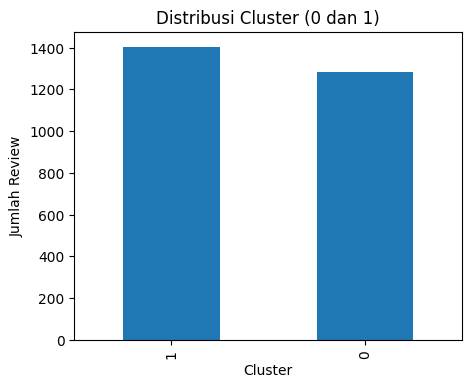

In [44]:
plt.figure(figsize=(5,4))
df['cluster'].value_counts().plot(kind='bar')
plt.title("Distribusi Cluster (0 dan 1)")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Review")
plt.show()

# **Evaluasi Model**

In [45]:
acc1 = accuracy_score(df['label'], df['cluster'])
acc2 = accuracy_score(df['label'], 1 - df['cluster'])

print(f"Akurasi (kemungkinan 1): {acc1:.3f}")
print(f"Akurasi (kemungkinan 2): {acc2:.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(df['label'], df['cluster']))

Akurasi (kemungkinan 1): 0.414
Akurasi (kemungkinan 2): 0.586

Confusion Matrix:
[[537 829]
 [746 577]]


In [46]:
print("\nContoh hasil akhir:")
print(df[['text', 'label', 'cluster', 'adjectives', 'entities']].head(5))


Contoh hasil akhir:
                                                text  label  cluster  \
0  When I put this movie in my DVD player, and sa...      0        1   
1  Even though I have great interest in Biblical ...      0        1   
2  A terrible movie as everyone has said. What ma...      0        0   
3  It may be the remake of 1987 Autumn's Tale aft...      1        0   
4  My Super Ex Girlfriend turned out to be a plea...      1        1   

                                          adjectives  \
0  [coke, first, awsome, good, excellent, funny, ...   
1           [great, biblical, bad, acting, horrible]   
2  [terrible, cameo, mcnealy, microsoft, instrume...   
3  [autumns, tale, eleven, mabel, personal, conse...   
4  [super, pleasant, horrible, predictable, know,...   

                                            entities  
0  [(first, ORDINAL), (Atlantis, PRODUCT), (first...  
1  [(Biblical, ORG), (every minute, TIME), (Joke,...  
2  [(Scott McNealy, PERSON), (SUN, ORG), (Mc

# **Interpretasi Cluster (Positif / Negatif)**

In [53]:
cluster_mean = df.groupby('cluster')['label'].mean()
print("\nRata-rata label per cluster:")
print(cluster_mean)

pos_cluster = cluster_mean.idxmax()
neg_cluster = cluster_mean.idxmin()

print(f"\nCluster {pos_cluster} = POSITIF")
print(f"Cluster {neg_cluster} = NEGATIF")

def get_vector(tokens):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

def prediksi_sentimen(teks):
    teks_bersih = clean_text(teks)
    fitur = get_vector(teks_bersih)
    fitur = fitur.reshape(1, -1)
    cluster_pred = kmeans.predict(fitur)[0]
    return "Negatif 😠" if cluster_pred == pos_cluster else "Positif 😀"

contoh_komentar = [
    "I really love this movie, it's so emotional and beautiful!",
    "This was the worst film I've ever seen.",
    "The acting was okay but the story was boring.",
    "Absolutely fantastic! I would watch it again.",
    "The plot was confusing and the ending was terrible.",
    "The cinematography is stunning and the soundtrack is lovely!"
]

for c in contoh_komentar:
    print(f"{c} → {prediksi_sentimen(c)}")


Rata-rata label per cluster:
cluster
0    0.581450
1    0.410384
Name: label, dtype: float64

Cluster 0 = POSITIF
Cluster 1 = NEGATIF
I really love this movie, it's so emotional and beautiful! → Positif 😀
This was the worst film I've ever seen. → Positif 😀
The acting was okay but the story was boring. → Positif 😀
Absolutely fantastic! I would watch it again. → Positif 😀
The plot was confusing and the ending was terrible. → Positif 😀
The cinematography is stunning and the soundtrack is lovely! → Negatif 😠


Dari hasil ini terlihat bahwa model masih belum sepenuhnya akurat dalam membedakan konteks kalimat negatif, terutama jika ada kata positif di dalam kalimat negatif *(misalnya “acting was okay but story boring”).*